# 3 Additional Functions with Keras

- 3.1 모델 합치기 with CIFAR10
- 3.2 데이터 증강
- 3.3 Finetuning
- 3.4 LSTM with MNIST
- 3.5 GAN with MNIST

## 3.1 모델 합치기 with CIFAR10

convolution과 maxpooling layer로 구성된 feature extractor 모델과

fully connected layer로 구성된 ANN classifier 모델을 따로 정의하고

두 모델을 합쳐서 CNN 모델을 만듬

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### (1) 데이터셋 : CIFAR 10

170508288/170498071 [==============================] - 60s 0us/step
(50000, 32, 32, 3) (50000, 1)
label :  [6]
(50000, 32, 32, 3) (50000, 10)


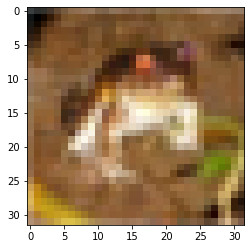

In [2]:
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets

# Dataset Load
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()

# Dataset Confirm
print(X_train.shape, Y_train.shape)
print('label : ',Y_train[0])
plt.imshow(X_train[0])

# Dataset Preprocessing
X_train = X_train/255.0
X_test = X_test/255.0
Y_train = utils.to_categorical(Y_train)
Y_test = utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

In [5]:
X_train

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [6]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

### (2) 모델링

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [9]:
n_in = X_train.shape[1:]
n_out = Y_train.shape[-1]

def conv_maxpool_layers(n_in):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(n_in)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', strides=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def fc_layers(n_out):
    model = Sequential()
    model.add(Dense(units =128, input_shape=(2048,), activation='relu'))
    model.add(Dense(units =n_out, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def CNN_sum(n_in, n_out):
    
    # Coding Time
    
    #각 부분 모델
    feature_extractor = conv_maxpool_layers(n_in)
    feature_extractor.trainable = True
    
    ann_classifier = fc_layers(n_out)
    ann_classifier.trainable = True

    
    #두 모델을 합쳐 새로운 모델 정의(Functional Style)
    x = Input(shape = n_in)
    feature = feature_extractor(x)
    y = ann_classifier(feature)
    model = Model(inputs = x, outputs = y)

    
    '''
    Sequential Style
    model = Sequential()
    model.add(feature_extractor)
    model.add(ann_classifier)
    '''
    return model

In [10]:
model = CNN_sum(n_in, n_out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 2048)              5088      
_________________________________________________________________
sequential_3 (Sequential)    (None, 10)                263562    
Total params: 268,650
Trainable params: 268,650
Non-trainable params: 0
_________________________________________________________________


### (3-4) 모델의 학습과정 설정 / 모델 학습

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(X_train, Y_train, 
                    batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

2022-09-06 14:38:08.110766: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-09-06 14:38:09.292733: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-09-06 14:38:10.297584: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-06 14:38:10.298159: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-06 14:38:10.298185: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-09-06 14:38:10.298760: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-06 14:38:10.298819: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-06 14:38:11.376452: I tensorflow/stream_executor/cuda/c

313/313 [==============================] - 6s 8ms/step - loss: 1.6171 - accuracy: 0.4277 - val_loss: 1.3453 - val_accuracy: 0.5314
Epoch 2/50
313/313 [==============================] - 2s 6ms/step - loss: 1.2435 - accuracy: 0.5628 - val_loss: 1.2004 - val_accuracy: 0.5892
Epoch 3/50
313/313 [==============================] - 2s 6ms/step - loss: 1.0988 - accuracy: 0.6144 - val_loss: 1.1142 - val_accuracy: 0.6114
Epoch 4/50
313/313 [==============================] - 2s 6ms/step - loss: 1.0114 - accuracy: 0.6480 - val_loss: 1.0979 - val_accuracy: 0.6181
Epoch 5/50
313/313 [==============================] - 2s 6ms/step - loss: 0.9400 - accuracy: 0.6726 - val_loss: 1.0164 - val_accuracy: 0.6502
Epoch 6/50
313/313 [==============================] - 2s 6ms/step - loss: 0.8831 - accuracy: 0.6931 - val_loss: 0.9980 - val_accuracy: 0.6546
Epoch 7/50
313/313 [==============================] - 2s 6ms/step - loss: 0.8364 - accuracy: 0.7089 - val_loss: 0.9869 - val_accuracy: 0.6559
Epoch 8/50
313/31

### (5) 모델 평가

In [12]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 0s 4ms/step - loss: 1.0094 - accuracy: 0.6674
loss : 1.0094, accruracy : 0.6674


## 3.2 Image data augmentation
케라스에서는 ImageDataGenerate 함수로 Data augmentation 기능을  제공

https://keras.io/preprocessing/image/#imagedatagenerator-class

### (1)-2 데이터 증강 적용

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

In [14]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 2, # 회전
    zoom_range = 0.1, # 확대 축소
    width_shift_range = 0.1, # 수평 이동
    height_shift_range = 0.1, # 수직 이동
    horizontal_flip = True, # 수평 반전|
    vertical_flip = False # 수직 반전
)

datagen.fit(X_train)

### (3-4) 모델의 학습과정 설정 / 모델 학습

In [16]:
model = CNN_sum(n_in, n_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)

# Coding Time
model.fit(datagen.flow(X_train[:-10000], Y_train[:-10000], batch_size = 18),
          epochs = 50, validation_data = (X_train[-10000:], Y_train[-10000:]),
          verbose = 1, callbacks = [earlystopper])

Epoch 1/50
2223/2223 [==============================] - 43s 19ms/step - loss: 1.5057 - accuracy: 0.4586 - val_loss: 1.2466 - val_accuracy: 0.5599
Epoch 2/50
2223/2223 [==============================] - 44s 20ms/step - loss: 1.2229 - accuracy: 0.5645 - val_loss: 1.0959 - val_accuracy: 0.6211
Epoch 3/50
2223/2223 [==============================] - 42s 19ms/step - loss: 1.1150 - accuracy: 0.6041 - val_loss: 1.0364 - val_accuracy: 0.6420
Epoch 4/50
2223/2223 [==============================] - 41s 19ms/step - loss: 1.0481 - accuracy: 0.6289 - val_loss: 1.0282 - val_accuracy: 0.6486
Epoch 5/50
2223/2223 [==============================] - 42s 19ms/step - loss: 1.0001 - accuracy: 0.6439 - val_loss: 0.9863 - val_accuracy: 0.6637
Epoch 6/50
2223/2223 [==============================] - 43s 19ms/step - loss: 0.9729 - accuracy: 0.6566 - val_loss: 0.9078 - val_accuracy: 0.6895
Epoch 7/50
2223/2223 [==============================] - 42s 19ms/step - loss: 0.9394 - accuracy: 0.6693 - val_loss: 0.9194 -

In [17]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 0s 4ms/step - loss: 0.8387 - accuracy: 0.7282
loss : 0.8387, accruracy : 0.7282


## 3.3 Transfer learning
Transfer learning을 통해 현재 쓰이고 있는 네트워크를 가져와 학습하는 방법을 배워본다(Classifier만 / Entire)

### (2) 모델링1 : Classifier learning
    
사용가능 네트워크 :
https://keras.io/api/applications/

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [19]:
# Coding Time
base_model = VGG16(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)
base_model.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [20]:
# Coding Time
# Get Feature Extroactor from VGG16
x = base_model.output

# Add Classifier
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
predictions = Dense(Y_train.shape[1], activation = 'softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

### (3) 모델의 학습과정 설정

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (4) 모델 학습시키기

In [24]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/50
313/313 [==============================] - 6s 14ms/step - loss: 1.7135 - accuracy: 0.3965 - val_loss: 1.4134 - val_accuracy: 0.5207
Epoch 2/50
313/313 [==============================] - 4s 11ms/step - loss: 1.5529 - accuracy: 0.4535 - val_loss: 1.3435 - val_accuracy: 0.5379
Epoch 3/50
313/313 [==============================] - 4s 11ms/step - loss: 1.5064 - accuracy: 0.4694 - val_loss: 1.3127 - val_accuracy: 0.5510
Epoch 4/50
313/313 [==============================] - 4s 11ms/step - loss: 1.4829 - accuracy: 0.4754 - val_loss: 1.2946 - val_accuracy: 0.5567
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 1.4580 - accuracy: 0.4859 - val_loss: 1.2774 - val_accuracy: 0.5559
Epoch 6/50
313/313 [==============================] - 4s 11ms/step - loss: 1.4356 - accuracy: 0.4920 - val_loss: 1.2761 - val_accuracy: 0.5576
Epoch 7/50
313/313 [==============================] - 4s 11ms/step - loss: 1.4216 - accuracy: 0.4979 - val_loss: 1.2562 - val_accuracy: 0.5703

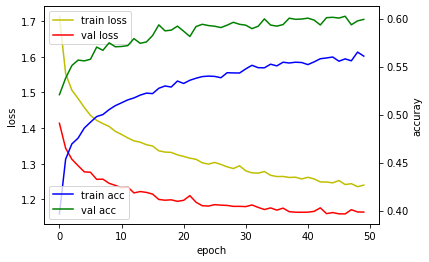

In [25]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### (5) 모델 평가하기

In [26]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 1s 8ms/step - loss: 1.1796 - accuracy: 0.5901
loss : 1.1796, accruracy : 0.5901


### (2) 모델링1 : Entire
    
사용가능 네트워크 :
https://keras.io/api/applications/

In [27]:
# Get Feature Extroactor from VGG16
x = base_model.output

# Add Classifier
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
predictions = Dense(Y_train.shape[1], activation='softmax')(x) #Y_train.shape[1] :10 

model = Model(inputs=base_model.input, outputs=predictions)

In [28]:
# first: train the all layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = True

In [29]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

### (3) 모델의 학습과정 설정

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (4) 모델 학습시키기

In [31]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/50
313/313 [==============================] - 9s 25ms/step - loss: 1.9773 - accuracy: 0.1901 - val_loss: 1.8646 - val_accuracy: 0.2233
Epoch 2/50
313/313 [==============================] - 7s 22ms/step - loss: 1.7744 - accuracy: 0.2491 - val_loss: 2.3708 - val_accuracy: 0.2352
Epoch 3/50
313/313 [==============================] - 7s 22ms/step - loss: 1.5161 - accuracy: 0.3778 - val_loss: 1.3877 - val_accuracy: 0.4539
Epoch 4/50
313/313 [==============================] - 7s 22ms/step - loss: 1.2848 - accuracy: 0.5001 - val_loss: 1.3973 - val_accuracy: 0.4873
Epoch 5/50
313/313 [==============================] - 7s 23ms/step - loss: 1.1026 - accuracy: 0.5829 - val_loss: 1.0308 - val_accuracy: 0.6171
Epoch 6/50
313/313 [==============================] - 7s 23ms/step - loss: 0.9496 - accuracy: 0.6459 - val_loss: 0.9569 - val_accuracy: 0.6536
Epoch 7/50
313/313 [==============================] - 7s 23ms/step - loss: 0.8357 - accuracy: 0.6965 - val_loss: 0.9181 - val_accuracy: 0.6703

KeyboardInterrupt: 

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### (5) 모델 평가하기

In [ ]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

## 3.4 LSTM with MNIST

### (1) 데이터셋

In [32]:
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
(X_train, Y_train),(X_test, Y_test) = datasets.mnist.load_data()
X_train_norm = X_train.astype('float32')/255.0
X_test_norm = X_test.astype('float32')/255.0
Y_train_onehot = utils.to_categorical(Y_train)
Y_test_onehot = utils.to_categorical(Y_test)

print(X_train_norm.shape, Y_train_onehot.shape)
n_in = X_train.shape[1:]
n_out = Y_train_onehot.shape[-1]

(60000, 28, 28) (60000, 10)


### (2) 모델링

In [34]:
def lstm(n_in, n_out):
    # Coding Time
    model = Sequential()
    model.add(LSTM(30, input_shape = n_in))
    model.add(Dense(n_out, activation = 'softmax'))
    return model

model = lstm(n_in, n_out)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                7080      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                310       
Total params: 7,390
Trainable params: 7,390
Non-trainable params: 0
_________________________________________________________________


### (3) 모델의 학습과정 설정

In [35]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (4) 모델 학습

In [36]:
# Coding Time
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train_norm, Y_train_onehot, batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/50
375/375 [==============================] - 5s 10ms/step - loss: 1.2489 - accuracy: 0.6021 - val_loss: 0.6690 - val_accuracy: 0.8055
Epoch 2/50
375/375 [==============================] - 3s 9ms/step - loss: 0.5409 - accuracy: 0.8382 - val_loss: 0.4302 - val_accuracy: 0.8744
Epoch 3/50
375/375 [==============================] - 3s 9ms/step - loss: 0.3623 - accuracy: 0.8930 - val_loss: 0.3428 - val_accuracy: 0.8946
Epoch 4/50
375/375 [==============================] - 3s 9ms/step - loss: 0.2823 - accuracy: 0.9165 - val_loss: 0.2414 - val_accuracy: 0.9286
Epoch 5/50
375/375 [==============================] - 3s 9ms/step - loss: 0.2321 - accuracy: 0.9310 - val_loss: 0.2236 - val_accuracy: 0.9333
Epoch 6/50
375/375 [==============================] - 3s 9ms/step - loss: 0.1986 - accuracy: 0.9414 - val_loss: 0.1731 - val_accuracy: 0.9504
Epoch 7/50
375/375 [==============================] - 3s 9ms/step - loss: 0.1737 - accuracy: 0.9488 - val_loss: 0.1556 - val_accuracy: 0.9554
Epoch

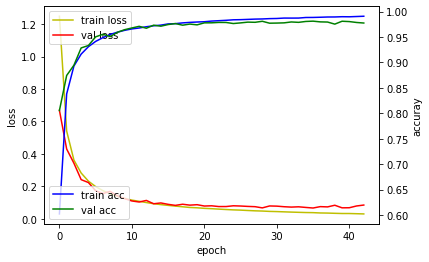

In [37]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### (5) 모델 평가하기

In [ ]:
loss_and_accuracy = model.evaluate(X_test_norm, Y_test_onehot, batch_size=128, verbose=1)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0], loss_and_accuracy[1]))

## 3.5 GAN with MNIST

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [39]:
from keras.layers import Input, Dense, Dropout, LeakyReLU
from keras.models import Model, Sequential
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras import initializers

In [40]:
# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정합니다.
np.random.seed(10)

# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 100

### (1) 데이터셋

In [41]:
def load_minst_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5 # -1~1 사이의 값
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test) # Label에 대한 진행이 없어도 됨

### (2-3) 모델링 / 모델 학습과정 설정

In [42]:
# Adam Optimizer를 사용합니다.
def get_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

# Generator 만들기
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# Discriminator 만들기
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [47]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # Coding Time
    discriminator.trainable = False # Generator와 Discriminator를 동시에 학습시 trainable을 False로 설정

    gan_input = Input(shape=(random_dim,)) # gan_input : 노이즈(100 차원)

    x = generator(gan_input) # X:이미지

    gan_output = discriminator(x) # gan_output : 이미지가 진짜인지 아닌지에 대한 확률

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [44]:
# 생성된 MNIST 이미지 출력
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

### (4) 모델 학습

In [45]:
def train(epochs=1, batch_size=128):
    # train 데이터와 test 데이터를 가져옵니다.
    x_train, y_train, x_test, y_test = load_minst_data()

    # train 데이터를 128 사이즈의 batch 로 나눕니다.
    batch_count = x_train.shape[0] // batch_size

    # 우리의 GAN 네트워크를 만듭니다.
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Coding Time
            # 입력으로 사용할 random 노이즈와 이미지를 가져옵니다.
            noise = np.random.normal(0, 1, size = [batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size = batch_size)]
            
            # Generator를 통해 MNIST 이미지를 생성
            generated_images = generator.predict(noise, verbose =0)
            X = np.concatenate([image_batch, generated_images])


            # Discriminator 학습
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Generator 학습
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
            
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

--------------- Epoch 1 ---------------


100%|█████████████████████████████████████████| 468/468 [00:32<00:00, 14.58it/s]


--------------- Epoch 2 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.44it/s]


--------------- Epoch 3 ---------------


100%|█████████████████████████████████████████| 468/468 [00:31<00:00, 14.70it/s]


--------------- Epoch 4 ---------------


100%|█████████████████████████████████████████| 468/468 [00:31<00:00, 15.06it/s]


--------------- Epoch 5 ---------------


100%|█████████████████████████████████████████| 468/468 [00:31<00:00, 14.71it/s]


--------------- Epoch 6 ---------------


100%|█████████████████████████████████████████| 468/468 [00:31<00:00, 15.09it/s]


--------------- Epoch 7 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.22it/s]


--------------- Epoch 8 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.11it/s]


--------------- Epoch 9 ---------------


100%|█████████████████████████████████████████| 468/468 [00:31<00:00, 15.09it/s]


--------------- Epoch 10 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.31it/s]


--------------- Epoch 11 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.28it/s]


--------------- Epoch 12 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.51it/s]


--------------- Epoch 13 ---------------


100%|█████████████████████████████████████████| 468/468 [00:31<00:00, 15.03it/s]


--------------- Epoch 14 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.21it/s]


--------------- Epoch 15 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.24it/s]


--------------- Epoch 16 ---------------


100%|█████████████████████████████████████████| 468/468 [00:31<00:00, 15.06it/s]


--------------- Epoch 17 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.41it/s]


--------------- Epoch 18 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.24it/s]


--------------- Epoch 19 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.16it/s]


--------------- Epoch 20 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.10it/s]


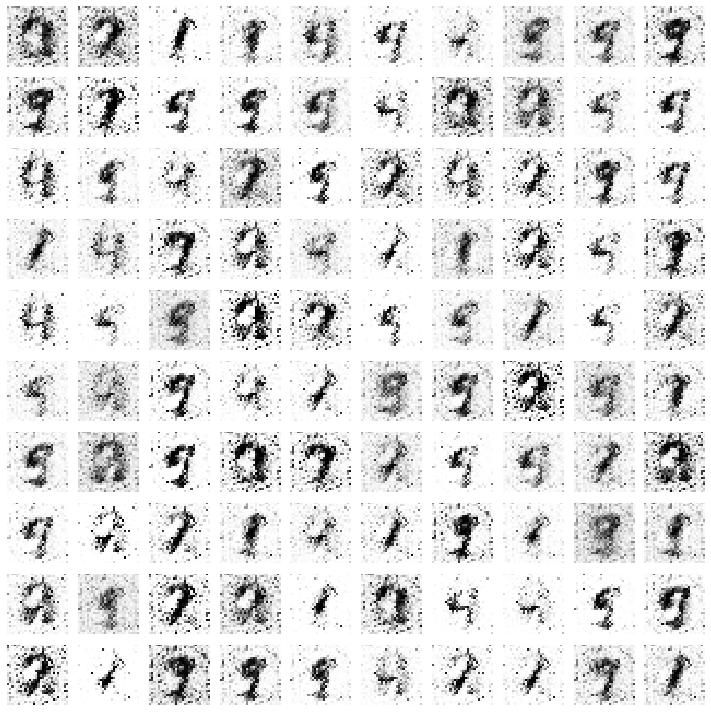

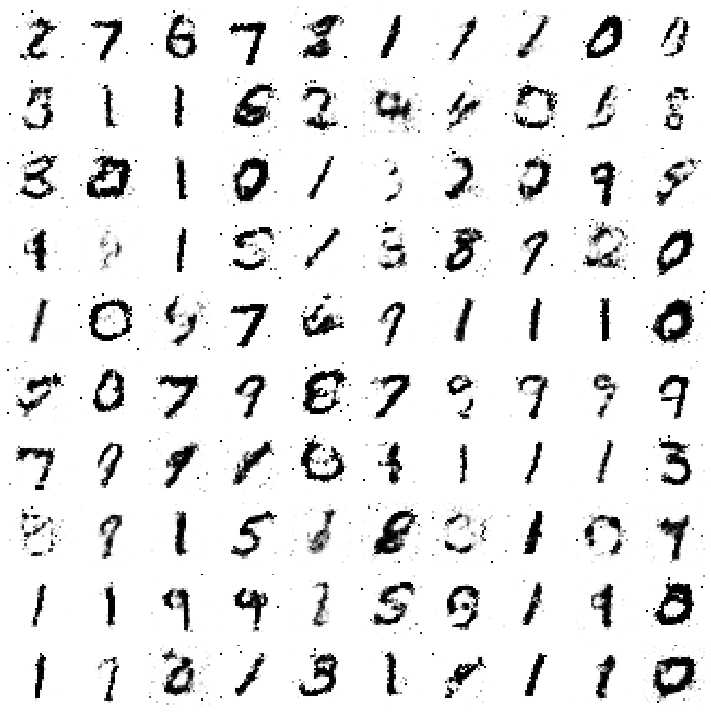

In [48]:
train(20, 128)